In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
path = r'\Deep Learning\datasets\digits'
path_train = path + r'\train.csv'
path_test = path + r'\test.csv'

In [45]:
def one_hot(data, num_classes):
    new_data = np.zeros((data.shape[0], num_classes))
    new_data[np.arange(data.shape[0]), data] = 1
    return new_data

In [46]:
data_train = np.array(pd.read_csv(path_train))
data_test = np.array(pd.read_csv(path_test))

In [47]:
X_train = data_train[:, 1:] / 255.0
y_train = one_hot(data_train[:, 0], 10)

X_test = data_test / 255.0

In [48]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [49]:
def softmax(x, derv=False):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = x_exp / x_exp.sum(axis=1, keepdims=True)
    if derv: return s * (1 - s)
    return s

In [50]:
def CCE(y, y_pred, epsilon=1e-8, derv=False):
    if derv: return y_pred-y # In this case
    return -np.mean(y*np.log(y_pred+epsilon))

In [51]:
def accuracy(y, y_pred):
    return np.mean(np.argmax(y, axis=1)==np.argmax(y_pred, axis=1))

In [52]:
n_INPUTS = X_train.shape[1]
n_hidden1 = 64
n_hidden2 = 32
n_OUTPUTS = y_train.shape[1]

In [53]:
# Layer 1
W0 = np.random.randn(n_INPUTS, n_hidden1) * np.sqrt(2/n_INPUTS)
b0 = np.zeros((1, n_hidden1))

# Layer 2
W1 = np.random.randn(n_hidden1, n_hidden2) * np.sqrt(2/n_hidden1)
b1 = np.zeros((1, n_hidden2))

# Layer 3
W2 = np.random.randn(n_hidden2, n_OUTPUTS) * np.sqrt(2/n_hidden2)
b2 = np.zeros((1, n_OUTPUTS))

params = [W0, b0, W1, b1, W2, b2]
len_params = len(params)

In [54]:
# Hyperparameters
EPOCHS = 5
BATCH_SIZE = 128
PRINT_EVERY = 0.1

In [55]:
# Adadelta settings
decay = 0
cache = [0] * len_params
delta = [0] * len_params
rho = 0.95
t = 1
epsilon_adadelta = 1e-8

In [ ]:
def adadelta_optimizer(grads, i):
    cache[i] = rho * cache[i] + (1 - rho) * grads**2
    update = (np.sqrt(delta[i] + epsilon_adadelta) / np.sqrt(cache[i] + epsilon_adadelta)) * grads
    delta[i] = rho * delta[i] + (1 - rho) * update**2
    return update

In [57]:
def forward(x):
    global z0, a0, z1, a1, z2, a2
    
    z0 = x @ W0 + b0
    a0 = ReLU(z0)
    
    z1 = a0 @ W1 + b1
    a1 = ReLU(z1)

    z2 = a1 @ W2 + b2
    a2 = softmax(z2)

    return a2

In [58]:
def prev_update():
    pass

In [59]:
def post_update():
    global t
    t += 1

In [60]:
def update_params(grads):
    prev_update()
    for i in range(len_params):
        params[i] -= adadelta_optimizer(grads[i], i)
    post_update()

In [61]:
def backward(x=None, y=None, outp=None, deltas=None, learn=True):
    if y is not None:
        dL = CCE(y, outp, derv=True)
    elif deltas is not None:
        dL = deltas
    else: raise ValueError('There is no (y) or (deltas).')
    # dL *= softmax(z2, derv=True)
    m = dL.shape[0]

    dW2 = a1.T @ dL / m
    db2 = dL.sum(axis=0, keepdims=True) / m

    da1 = dL @ W2.T
    dz1 = da1 * ReLU(z1, derv=True)

    dW1 = a0.T @ dz1 / m
    db1 = dz1.sum(axis=0, keepdims=True) / m

    da0 = dz1 @ W1.T
    dz0 = da0 * ReLU(z0, derv=True)

    dW0 = x.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    deltas = dz0 @ W0.T

    if learn:
        update_params((dW0, db0, dW1, db1, dW2, db2))
    
    return deltas, dW0, dW1, dW2, db0, db1, db2

In [62]:
def train(x, y, epochs=150, batch_size=128, print_every=0.1, shuffle=True):
    for epoch in range(1, epochs+1):
        if shuffle:
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]
        
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]

            predictions = forward(x_batch)
            backward(x_batch, y_batch, predictions, learn=True)

        if epoch % max(1, int(epochs * print_every)) == 0:
            loss = CCE(y, forward(x))
            acc = accuracy(y, forward(x))
            print(f'Epochs: [{epoch}/{epochs}]> Loss: {loss:.4f} | Acc: {acc:.4f}')

In [63]:
train(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    print_every=PRINT_EVERY,
    shuffle=True
)

Epochs: [1/5]> Loss: 0.0329 | Acc: 0.9089
Epochs: [2/5]> Loss: 0.0266 | Acc: 0.9203
Epochs: [3/5]> Loss: 0.0213 | Acc: 0.9404
Epochs: [4/5]> Loss: 0.0190 | Acc: 0.9464
Epochs: [5/5]> Loss: 0.0176 | Acc: 0.9507


In [64]:
accuracy(y_train, forward(X_train))

np.float64(0.9506666666666667)

Prediction: 4


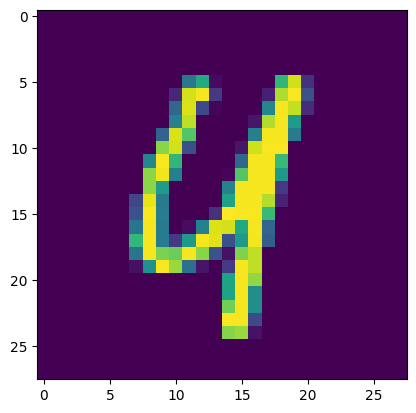

In [74]:
random_idx = np.random.randint(0, X_test.shape[0])
random_image = X_test[random_idx]
print(f'Prediction: {np.argmax(forward(random_image.reshape(1, -1)))}')
plt.imshow(random_image.reshape(28, 28))
plt.show()